# Online News Popularity Analysis and Prediction

In the recent decades, internet has become a popular source for people to learn about news. Among all the news published online, some become really popular, but others do not. In this project, we aim to predict whether a news article will become popular or not, based on some characteristics of the article, such as number of words, article topic, and etc.

In this notebook, we will use multiple machine learning models, such as KNN, Naive Bayes, QDA, LDA, Logistic Regression and Random Forest to perform classification. We will then compare the CV scores to determine the most appropriate model.

In [26]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Data Exploration and Feature Engineering

The dataset is collected from a well-known news website called Mashable, and the dataset is provided by UCI machine learning repository (https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

In the original dataset, there are 39,797 instances, with 61 features. 
Performed the following to clean up the dataset:
1. Columns contain news’ URL and days between the article publication and the dataset acquisition have been deleted (irrelevant information).

2. Combine the channel into one column (named as channel), and use numbers to represent each channel:
    1: Lifestyle
    2: Entertainment
    3: Business
    4: Social
    5: Tech
    6: World
    Delete the instance if channel information is missing (6287 instances have been deleted)
    
3. Combine the days into one column (named as days): 1 represents Mondy, 2 represents Tuesday, etc. Delete the column “is_weekend” (repetitive information).

    
After the cleaning process, the resulting dataset contains 33,510 instances, with 47 features.

(The above steps are performed directly on the csv data file in excel.)

### Assign the class

The goal is to perform the classification algorithm, so that based on the features of an article, we will be able to predict whether it will become popular or not. Thus, the first step is to define what is popular and what is not.

We will use the column "shares" as an indicator of popularity. Explore the "shares" column":

In [1]:
import pandas as pd
df = pd.read_csv('OnlineNewsPopularity.csv', sep=',') 

In [10]:
print(df[' shares'].describe())

count     33510.000000
mean       2928.637989
std        9470.520277
min           1.000000
25%         930.000000
50%        1400.000000
75%        2500.000000
max      690400.000000
Name:  shares, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x119483128>,
 'caps': [<matplotlib.lines.Line2D at 0x1194839e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x119474f98>],
 'medians': [<matplotlib.lines.Line2D at 0x11948f278>],
 'fliers': [<matplotlib.lines.Line2D at 0x11948f6a0>],
 'means': []}

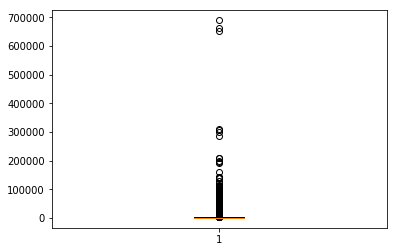

In [13]:
plt.boxplot(df[' shares'])

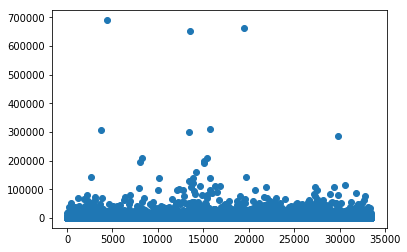

In [14]:
df[' shares'].plot(style='o')

From the boxplot and statistics summary, we could see that the target column "shares" has some outliers, but most of them are under 2500. For our purpose, we will regard the articles with shares > 1400 as popular, and not popular otherwise.

For the convenience of future use, directly add a column called "class" in the data csv file, and assign the classes as described above. The dataset is stored in "OnlineNewsPopularity2".csv

### Feature Selection - Fisher Score

We firstly calculate the Fisher Score of each feature, and rank them from the largest to smallest. 

F-score provides a measure of how well a single feature at a time can discriminate between different classes. The higher the F-score, the better the discriminatory power of that feature.

This process is performed using R, and the result table is shown here: 

(the R code is also available here:https://github.com/ruoxi430/News-Popularity )

<img src="picture.png" width="400">

We keep the top 25 features with highest F-score. The change is directly done with the data csv file, and the data are stored in "OnlineNewsPopularity4".csv

In the next step, we calculated the covariance matrix for further feature selection.

### Feature Selection -  Covariance Matrix

In [17]:
df2 = pd.read_csv('OnlineNewsPopularity4.csv', sep=',')

In [18]:
len(df2.columns)

27

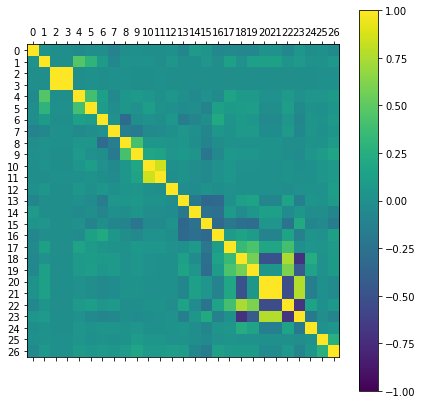

In [20]:
correlations = df2.corr()
# plot correlation matrix
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,27,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.show()

It is easy to see there are several variables have high correlation. After considering the nature of these features, we elimintaed 6 highly correalted varaibles.

The final cleaned dataset version is stored in "OnlineNewsPopularityCleaned2.csv", with 19 features.

In [34]:
df3 = pd.read_csv('OnlineNewsPopularityCleaned2.csv', sep=',')

In [35]:
len(df3.columns)

21

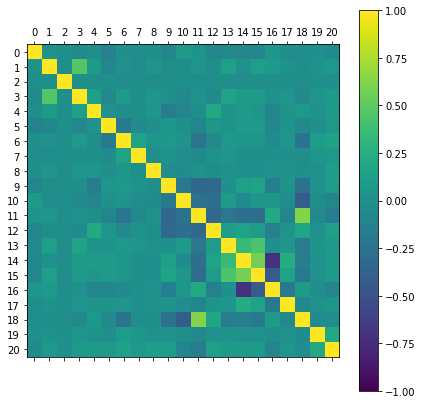

In [36]:
correlations2 = df3.corr()
# plot correlation matrix
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations2, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,21,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
plt.show()

Looks good now!

We could begin to train the classification models.

## Classification Models

### 1. KNN

After testing using different number of neighbors, we choose to use 10, as 10 gives the best performance.

In [37]:
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn import decomposition

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Cross Validation Avg =  0.5854371829304685


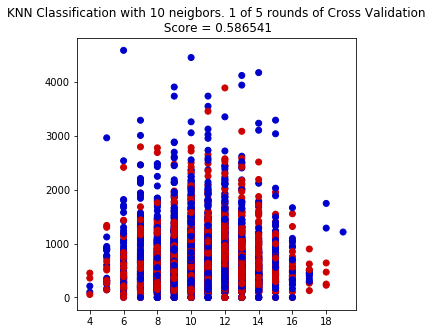

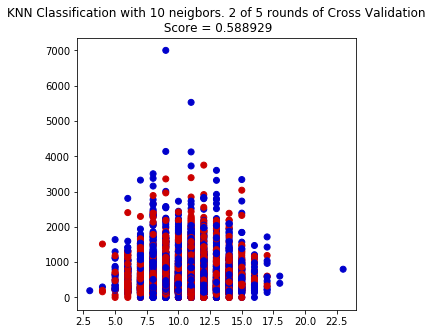

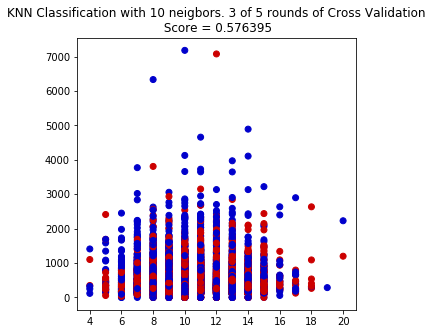

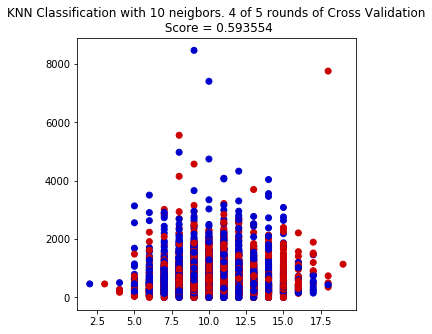

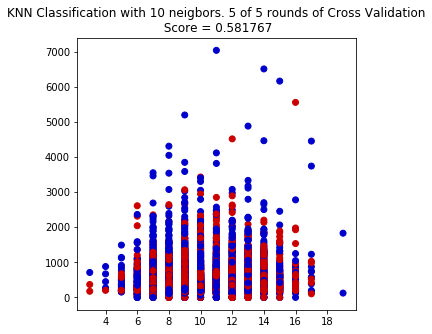

In [38]:
#pca = decomposition.PCA(n_components=4, whiten=True)
data = df3.as_matrix()
X = data[:,0:-2]
y = data[:,-1]
#X = pca.fit_transform(X)
no_of_classes = len(unique(y))
no_of_classes = 10
splits = 5
cv = KFold(n_splits=splits, shuffle=True)  # 5-fold cross-validation

# X=X[:,:2]

# plt.figure(figsize=(5,5))

clf_score_sum = 0
for k,(train, test) in enumerate(cv.split(X)):
    clf = neighbors.KNeighborsClassifier(n_neighbors=no_of_classes)
    clf.fit(X[train],y[train])
    ypred=clf.predict(X[test])

    plt.figure(figsize=(5,5))
    score = (clf.score(X[test],y[test]))
    clf_score_sum+=score


    # Plot also the training points
    plt.scatter(X[test,0], X[test,1], c=y[test], cmap=cmap_bold)
    plt.title("KNN Classification with %i neigbors. %i of %i rounds of Cross Validation\n Score = %g"
              
              % (no_of_classes, k+1, 5,score))

clf_score_avg = clf_score_sum/splits

print("Cross Validation Avg = ",clf_score_avg)

### 2. Logistic Regression, Naive Bayes, LDA, QDA

In [41]:
from sklearn.naive_bayes import GaussianNB 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [40]:
data2 = np.loadtxt('OnlineNewsPopularityCleaned2.csv', delimiter=',', skiprows=1)
target = data2[:,-1].reshape(len(data2),1)
features = data2[:,:-2]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30)

gnb = GaussianNB()
qda = QDA()
lda = LDA()
log = LogisticRegression()

In [44]:
print(mean(cross_val_score(gnb, features, target, cv=5)))
print(mean(cross_val_score(qda, features, target, cv=5)))
print(mean(cross_val_score(lda, features, target, cv=5)))
print(mean(cross_val_score(log, features, target, cv=5)))

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.5370915443986205


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.5432998625168988


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.6117018350450472


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

0.6066848309104856


### 3. Random Forest

In [45]:
df_t2 = pd.read_csv('OnlineNewsPopularityCleaned2.csv', sep=',')
data3 = df_t2.values

In [47]:
target3 = data3[1:,-1]
features3= data3[1:,:19]

In [8]:
#from sklearn import decomposition
#pca = decomposition.PCA(n_components=3, whiten=True)
#pca_feature = pca.fit_transform(features2)

In [48]:
from sklearn.ensemble import RandomForestClassifier
rf2 = RandomForestClassifier(n_estimators=300,max_depth=15,max_features=5)

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [50]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_target, test_target = train_test_split(features3, target3, test_size = 0.2, random_state = 42)

In [52]:
rf2.fit(train_features, train_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [54]:
cross_val_score(rf2, features3,target3, cv=5)

array([0.61345666, 0.65308863, 0.65652044, 0.67691389, 0.66527384])

In [55]:
np.mean([0.61345666, 0.65308863, 0.65652044, 0.67691389, 0.66527384])

0.6530506920000001

### Result Summary

The average accuracy of the classifiction models are:

KNN(K=10): 0.59

Logistic Regression: 0.61

Naive Bayes: 0.54

LDA:0.61

QDA:0.54

Random Forest:0.65


Random Forest has the best performance.

Also, from the random forest, we could also calcualte the feature importance:

In [67]:
df4 = pd.DataFrame(train_features)

In [68]:
df4.columns = ['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'num_hrefs', 'num_keywords', 'kw_min_min', 'kw_avg_avg', 'self_reference_avg_sharess', 'day', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 
               'rate_negative_words', 'title_sentiment_polarity', 'channel']

In [71]:
feature_importances = pd.DataFrame(rf2.feature_importances_,
                                   index = df4.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [72]:
feature_importances

,importance
kw_avg_avg,0.104235
self_reference_avg_sharess,0.074644
LDA_02,0.067658
LDA_00,0.061131
LDA_04,0.061016
n_unique_tokens,0.060523
LDA_01,0.060362
n_tokens_content,0.056902
global_subjectivity,0.055744
global_rate_positive_words,0.055733


From this, we could see that articles that refers to other popular articles, uses popular keywords, and discusses popular topics, are more likely to become popular.

### Will PCA help?

As there are 19 features in our dataset, we are wondering if performing PCA will make the models have better performances.

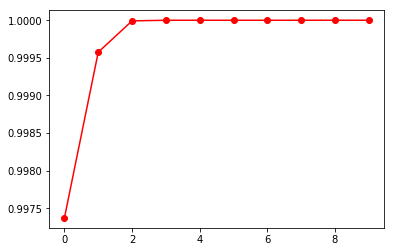

In [61]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=10)
pca.fit(features)
L = pca.explained_variance_
cl=np.cumsum(L)
plot(cl/cl[-1],'o-r')

It seems that most of the variances could be captured by the first 4 important PCA dimensions. So we decide to keep only 4 dimensions. 

Now re-run the random forest classification models:

In [62]:
pca = decomposition.PCA(n_components=3, whiten=True)
pca_feature = pca.fit_transform(features3)

In [63]:
rf3 = RandomForestClassifier(n_estimators=300,max_depth=3,max_features=3)

In [64]:
from sklearn.model_selection import cross_val_score
cross_val_score(rf3, pca_feature,target3, cv=5)

array([0.55497538, 0.60176067, 0.61235452, 0.61453514, 0.62587673])

In [65]:
np.mean([0.55497538, 0.60176067, 0.61235452, 0.61453514, 0.62587673])

0.601900488

In our study, PCA did not improve the results in any cases. Since variables in our data have low correlation, performing PCA will lead to information loss and consequently worsen the classification results.

## Future Work

Conclusively , this project was focused on predicting the popularity of news articles based on the number of shares of the articles. Given the high dimensionality of our data, we used fisher score to select the most relevant features. We then used several classification algorithms to classify the data. Our results show that the accuracy of the classification models is quite low with Random Forest being the highest with an accuracy of 65%. We then used PCA to process the data but it failed to improve the classification as expected.

To improve accuracy, there is limited room in model selection, but much room in feature selection. Although the original dataset contains 61 features, many of them are highly correlated and thus are removed. We believe that by adding additional features that could describe the news effectively, we will be able to improve the accuracy.

In the future, we could implement an efficient data cleaning method instead of manually removing and deleting features with missing data during the preprocessing stage. Also, due to the size of the data and limited computing power, we could not run some classification models like SVM. In the future we could use a computer with higher computation power to run these other classification models and see how they compare to our current results.